In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

In [34]:
sales = pd.read_csv("rollingsales_brooklyn.csv")
print(len(sales))
sales.dtypes

23373


BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

In [35]:
# Format columns
def format_num(s):
    return float(s.replace("$","").replace(",",""))

# Strip extra whitespace from strings
# Could also go further and convert everything to lowercase, collapse extra internal spaces, etc...
str_cols = sales.select_dtypes(["object"])
sales[str_cols.columns] = str_cols.apply(lambda x: x.str.strip())

# Format numbers that have dollar signs and or commas so they can actually be treated as numbers
num_cols = sales[["LAND SQUARE FEET", "SALE PRICE", "GROSS SQUARE FEET"]]
sales[num_cols.columns] = num_cols.apply(lambda x: x.apply(format_num,True))

# Turn date string into an actual date object
sales["SALE DATE"] = pd.to_datetime(sales["SALE DATE"])

In [36]:
# Select features we are interested in
sales = sales[["NEIGHBORHOOD", "BUILDING CLASS CATEGORY", "LAND SQUARE FEET", "GROSS SQUARE FEET", "YEAR BUILT", "SALE PRICE"]]
# Add a new feature for the total square feet
sales["TOTAL SQUARE FEET"] = sales["LAND SQUARE FEET"] + sales["GROSS SQUARE FEET"]
sales.describe()

,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,TOTAL SQUARE FEET
count,2.337300e+04,2.337300e+04,23373.000000,2.337300e+04,2.337300e+04
mean,3.558953e+03,3.005280e+03,1681.096436,5.283847e+05,6.564233e+03
std,7.830975e+04,2.295111e+04,658.095440,2.821726e+06,8.947425e+04
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1901.000000,0.000000e+00,0.000000e+00
50%,1.850000e+03,1.760000e+03,1925.000000,2.500000e+05,3.813000e+03
75%,2.500000e+03,3.000000e+03,1950.000000,6.141970e+05,5.374000e+03
max,7.446955e+06,2.548000e+06,2013.000000,2.769470e+08,8.992663e+06


In [37]:
# Based on the above summary data (and prior EDA!!!), we should get rid of some missing/invalid data
sales = sales[sales["NEIGHBORHOOD"] != ""]
sales = sales[sales["BUILDING CLASS CATEGORY"] != ""]
sales = sales[sales["LAND SQUARE FEET"] > 0]
sales = sales[sales["GROSS SQUARE FEET"] > 0]
sales = sales[sales["YEAR BUILT"] > 1900]
sales = sales[sales["SALE PRICE"] > 10000]
sales.describe()

,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,TOTAL SQUARE FEET
count,7101.000000,7.101000e+03,7101.000000,7.101000e+03,7.101000e+03
mean,3555.689621,4.851353e+03,1930.487255,1.046705e+06,8.407042e+03
std,17424.871027,3.320359e+04,25.220956,4.159173e+06,4.757257e+04
min,396.000000,1.000000e+02,1901.000000,1.100000e+04,8.320000e+02
25%,1890.000000,1.824000e+03,1915.000000,3.900000e+05,3.896000e+03
50%,2080.000000,2.515000e+03,1925.000000,6.000000e+05,4.862000e+03
75%,2715.000000,3.572000e+03,1931.000000,8.800000e+05,6.250000e+03
max,905000.000000,2.548000e+06,2012.000000,2.769470e+08,3.453000e+06


In [38]:
# Now let's use KNN to see if we can predict the neighborhood of a sale based on
# it's other various attributes

# First let's rule out outliers
sales_3std = sales[(np.abs(stats.zscore(sales[["GROSS SQUARE FEET","LAND SQUARE FEET","SALE PRICE"]])) < 3).all(axis=1)].copy()

# Our labels (y) are the neighborhood
y = sales_3std["NEIGHBORHOOD"]
# Our predictors are everything else
# Ignore building class because it is non-numeric (but maybe we could come up with a distance metric)
# Ignore Total Square Feet because it's already included in gross and land
x = sales_3std.drop(["NEIGHBORHOOD","BUILDING CLASS CATEGORY","TOTAL SQUARE FEET"],axis=1)

# Split out data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

# Create and fit a classifier with the default K=5
classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)
# Get the accuracy of our classifier on our test data
classifier.score(x_test, y_test)

0.10397727272727272

In [39]:
# The accuracy was terrible...but our data was of many different scales.
y = sales_3std["NEIGHBORHOOD"]
x = sales_3std.drop(["NEIGHBORHOOD","BUILDING CLASS CATEGORY","TOTAL SQUARE FEET"],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

# Scale our data using sklearns standard scaler (this is not the only way you can scale)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Check to see what the scaled data looks like
col_names = ["GROSS SQUARE FEET","LAND SQUARE FEET", "YEAR BUILT", "SALE PRICE"]
scaled_sales = pd.DataFrame(x_train, columns=col_names)
scaled_sales.describe()

,GROSS SQUARE FEET,LAND SQUARE FEET,YEAR BUILT,SALE PRICE
count,5.278000e+03,5.278000e+03,5.278000e+03,5.278000e+03
mean,7.175011e-17,2.965924e-18,-3.592207e-15,2.331195e-17
std,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00
min,-9.048729e-01,-6.096863e-01,-1.164260e+00,-7.722413e-01
25%,-3.375384e-01,-3.188876e-01,-6.071248e-01,-4.171334e-01
50%,-2.703241e-01,-2.025681e-01,-2.091709e-01,-2.253184e-01
75%,-3.877645e-02,-2.577963e-02,2.960150e-02,3.043186e-02
max,1.879196e+01,1.534627e+01,3.253029e+00,1.196946e+01


In [40]:
# Now re-train and re-score our model
classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.22897727272727272

In [43]:
# Significantly better but still not great...
# What if we try predicting the building class instead?
y = sales_3std["BUILDING CLASS CATEGORY"]
x = sales_3std.drop(["NEIGHBORHOOD","BUILDING CLASS CATEGORY","TOTAL SQUARE FEET"],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
classifier.score(x_test, y_test)

0.54375

In [47]:
# Much better accuracy...the predictors we are using seem better suited to
# predict building class than neighborhood. Let's see other stats for our model.
print(classification_report(y_test, y_pred,zero_division=0))

                                    precision    recall  f1-score   support

              01  ONE FAMILY HOMES       0.59      0.62      0.61       408
              02  TWO FAMILY HOMES       0.55      0.70      0.61       680
            03  THREE FAMILY HOMES       0.34      0.19      0.24       242
       05  TAX CLASS 1 VACANT LAND       0.00      0.00      0.00         1
   07  RENTALS - WALKUP APARTMENTS       0.61      0.63      0.62       234
 08  RENTALS - ELEVATOR APARTMENTS       0.77      0.67      0.71        15
   10  COOPS - ELEVATOR APARTMENTS       1.00      1.00      1.00         1
           14  RENTALS - 4-10 UNIT       0.46      0.20      0.28        56
              21  OFFICE BUILDINGS       0.30      0.14      0.19        21
               22  STORE BUILDINGS       0.20      0.10      0.14        39
                  26  OTHER HOTELS       0.00      0.00      0.00         1
                     27  FACTORIES       0.00      0.00      0.00        16
           

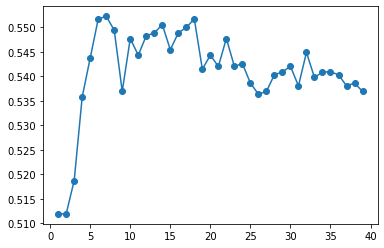

In [29]:
# One thing to notice is that there are a lot of 0 values...this occurs when there are
# either no predictions, or no truths for that category...so we may want more data,
# or maybe we could combine some categories sensibly (but that requires domain knowledge).
acc = []

for i in range(1,40):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(x_train, y_train)
    acc.append(classifier.score(x_test, y_test))
plt.plot(range(1,40), acc, marker='o')

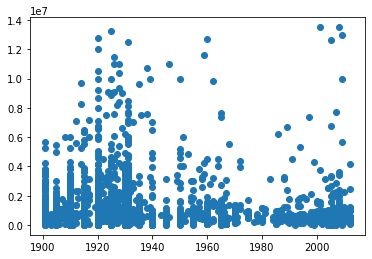

In [30]:
# Lets try to cluster our data, based on price and year and run our classifier on the clusters instead
plt.scatter(sales_3std["YEAR BUILT"], sales_3std["SALE PRICE"])

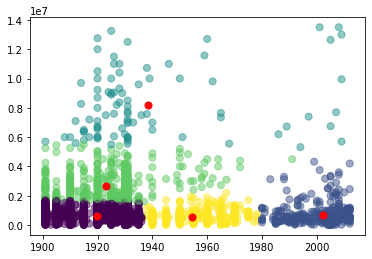

In [31]:
scaler = StandardScaler()
scaled_kmeans = pd.DataFrame(scaler.fit_transform(sales_3std[["YEAR BUILT", "SALE PRICE"]]),columns=["YEAR BUILT","SALE PRICE"])

kmeans = KMeans(n_clusters = 5).fit(scaled_kmeans)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(sales_3std["YEAR BUILT"], sales_3std["SALE PRICE"], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=50)

In [32]:
sales_3std["CLUSTER"] = np.array(kmeans.labels_)
print(sales_3std[sales_3std["CLUSTER"]==4].describe())
new_cheap = sales_3std[sales_3std["CLUSTER"]==4].copy()

       LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT    SALE PRICE  \
count        945.000000          945.00000   945.000000  9.450000e+02   
mean        2841.378836         2755.55873  1954.378836  5.573056e+05   
std         2260.872936         5101.46761     9.808029  2.938690e+05   
min          849.000000          725.00000  1937.000000  1.222300e+04   
25%         1960.000000         1725.00000  1945.000000  3.780000e+05   
50%         2123.000000         2070.00000  1955.000000  5.200000e+05   
75%         2950.000000         2760.00000  1960.000000  6.950000e+05   
max        27203.000000        98304.00000  1978.000000  2.200000e+06   

       TOTAL SQUARE FEET  CLUSTER  
count         945.000000    945.0  
mean         5596.937566      4.0  
std          6731.591826      0.0  
min          2089.000000      4.0  
25%          3721.000000      4.0  
50%          4286.000000      4.0  
75%          5720.000000      4.0  
max        116924.000000      4.0  


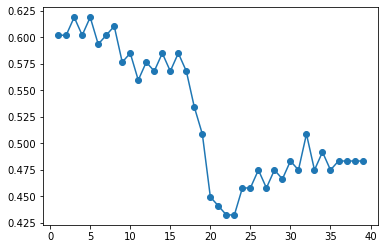

In [15]:
y = new_cheap["BUILDING CLASS CATEGORY"]
x = new_cheap.drop(["NEIGHBORHOOD","BUILDING CLASS CATEGORY","TOTAL SQUARE FEET"],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

acc = []

for i in range(1,40):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(x_train, y_train)
    acc.append(classifier.score(x_test, y_test))
plt.plot(range(1,40), acc, marker='o')